In [1]:
from keras.models import Model, load_model, model_from_json
import keras
from keras.datasets import cifar10
from keras import regularizers, callbacks
import sys
sys.path.append('C:/Users/320060820/Documents/prep_experiments/model_quantization')
from train_model import *
from inception_model import get_model
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
TRAIN = True
save_path = '../../saved models/'
num_classes = 10
epochs = 50
reduced_training_size_factor = 1
batch_size = 64

train_data, test_data = cifar10.load_data()
kernels = [20, 16, 32, 64]
model = get_model(input_shape=(96, 96, 3), nb_classes=10, 
                          nb_fabrics=49, scale_factor=96//96, 
                          resampling='conv', kernels=kernels, reg=None,
                          pool_layer='average', dropout=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 20)   560         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 20)   80          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 48, 48, 16)   336         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [4]:
if TRAIN:
    max_acc_callback = callbacks.EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10, mode='max', baseline=0.70, 
                                               restore_best_weights=True)
    m = callbacks.ModelCheckpoint(save_path + '/cifar_df_avgpool_dropout/model_{epoch:02d}_{val_acc:.2f}.h5',
                                 monitor='val_acc', mode='max')
    train_data, test_data, trained_model, history = train_model(
                    model, train_data, test_data, epochs, 
                    batch_size, num_classes, reduced_training_size_factor, rgb=True,
                    cb=[m])

    x_train_resize, y_train = train_data
    x_test_resize, y_test = test_data

#     trained_model.save(save_path + 'inception_cifar_dropout.h5')
else:
    _, (x_test_resize, y_test) = convert_data(training_data, testing_data, batch_size, num_classes, 
                                               reduced_training_size_factor)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 92s 2ms/step - loss: 1.5835 - acc: 0.4198 - val_loss: 1.8578 - val_acc: 0.4151
Epoch 2/50
50000/50000 [==============================] - 87s 2ms/step - loss: 1.1207 - acc: 0.6000 - val_loss: 1.3395 - val_acc: 0.5676
Epoch 3/50
50000/50000 [==============================] - 87s 2ms/step - loss: 0.9746 - acc: 0.6541 - val_loss: 1.1586 - val_acc: 0.6035
Epoch 4/50
50000/50000 [==============================] - 87s 2ms/step - loss: 0.8742 - acc: 0.6898 - val_loss: 1.1465 - val_acc: 0.6167
Epoch 5/50
50000/50000 [==============================] - 87s 2ms/step - loss: 0.8079 - acc: 0.7152 - val_loss: 1.0267 - val_acc: 0.6490
Epoch 6/50
50000/50000 [==============================] - 88s 2ms/step - loss: 0.7431 - acc: 0.7390 - val_loss: 1.2911 - val_acc: 0.6106
Epoch 7/50
50000/50000 [==============================] - 87s 2ms/step - loss: 0

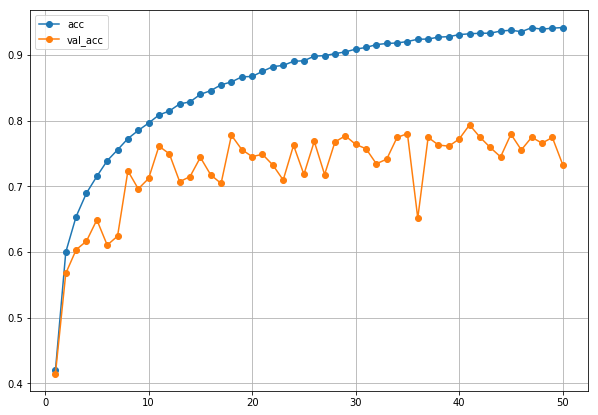

In [5]:
new_epochs = len(history.history['val_acc'])
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, new_epochs + 1), history.history['acc'], 'o-',label='acc')
plt.plot(np.arange(1, new_epochs + 1), history.history['val_acc'], 'o-', label='val_acc')
plt.legend()
plt.grid()